# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования** — проверяем гипотезы:
1. Как быстро продавались квартиры, какую продажу считать быстрой, а какую - долгой.
2. Определить зависимость цены от площади, этажа, даты подачи объявления. 
3. Найти цену одного квадратного метра, найти населенные пункты с самой низкой и самой высокой ценой за квадратный метр.
4. Определить как стоимость объектов зависит от расстояния до центра города. 

**Ход исследования**
 
Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Проверка гипотез.


### Откройте файл с данными и изучите общую информацию. 

Первое открытие csv показало, что там нестандартный разделитель, я его нашел с помощью csv.Sniffer, fp.read(5000) - чтобы не читать весь файл указал размер буфера.

In [1]:
import pandas as pd

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

Посмотрим на типы данных и количество ненулевых значений, для удобства можно пропуски в данных отдельно отобразить:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


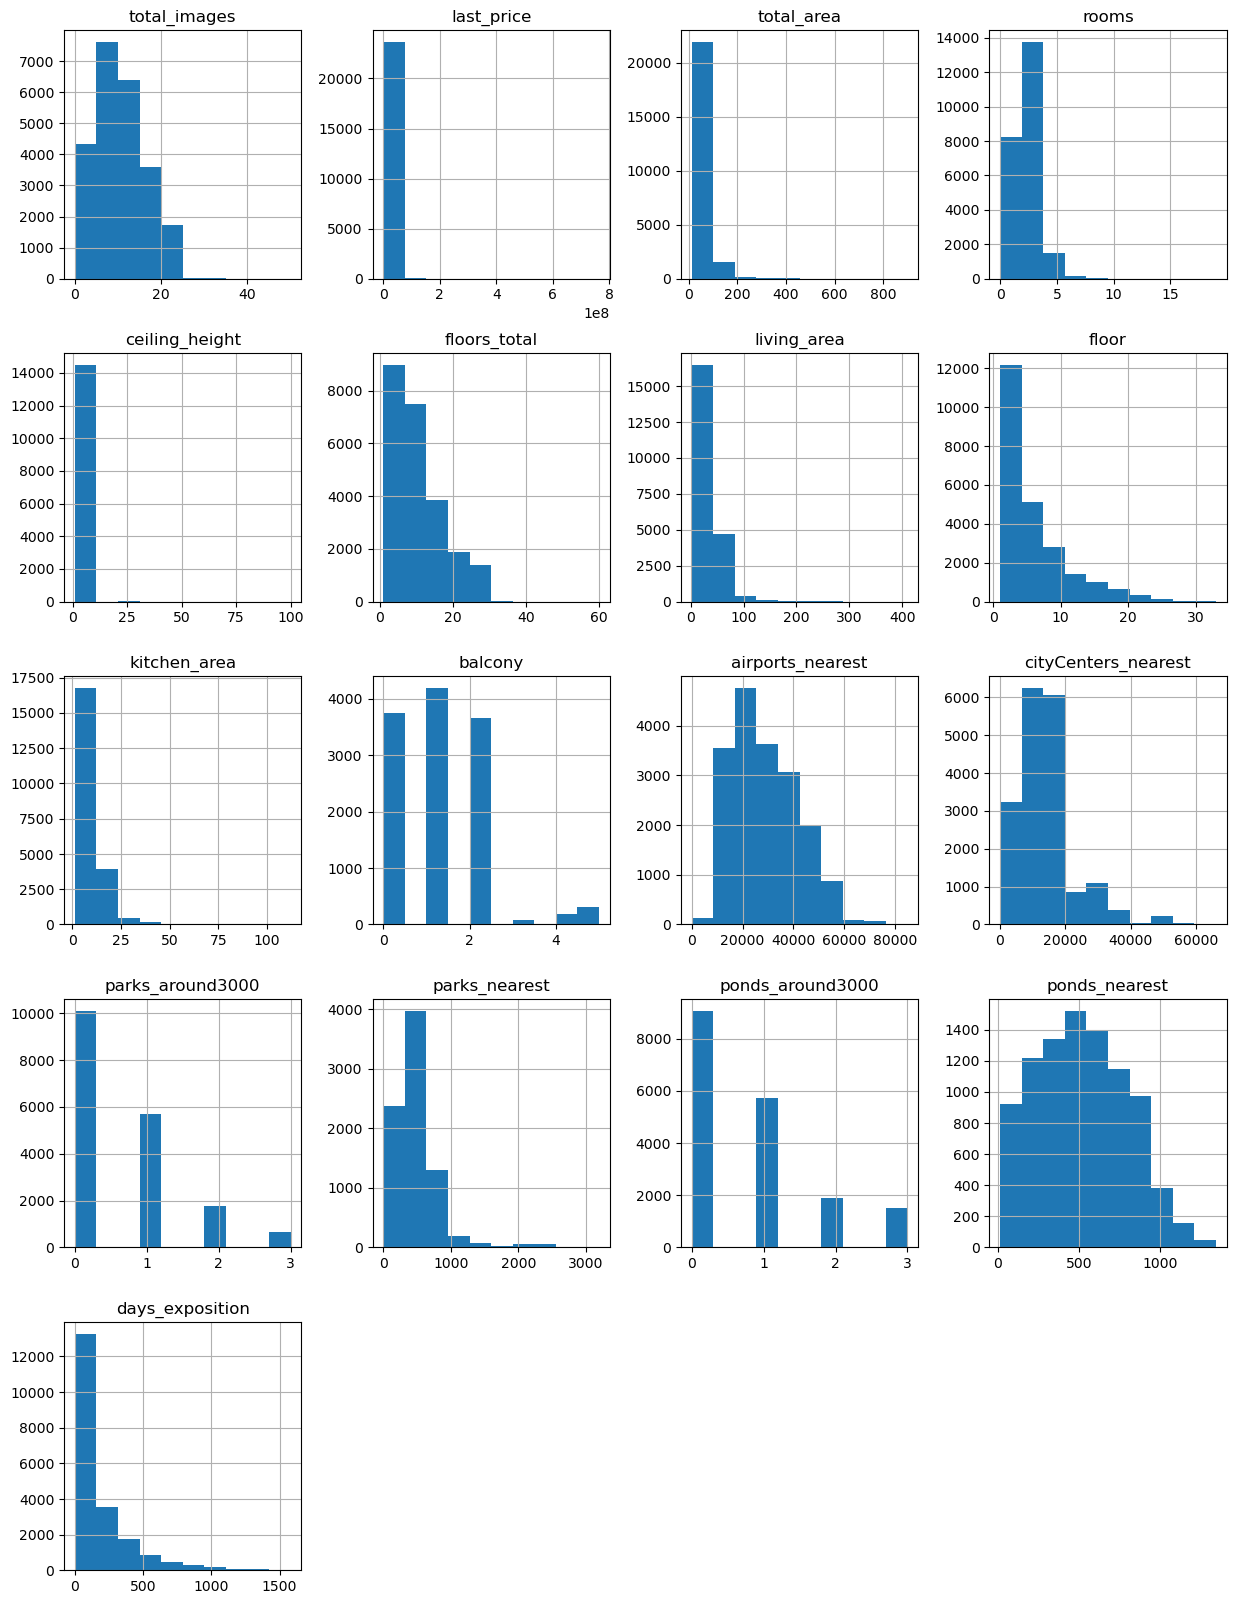

In [6]:
#Постройте общую гистограмму для всех столбцов таблицы.
data.hist(figsize=(15, 20));

### Вывод:

**посмотрев на типы данных и количества значений, выяснили:**

* first_day_exposition - object - должен быть тип datetime
* ceiling_height - пропуски
* floors_total - должен быть тип int, т.к. количество этажей - целое значение + пропуски данных
* is_apartment - должен быть тип bool + пропуски 
* living_area - пропуски
* kitchen_area - пропуски
* balcony - пропуски
* locality_name - пропуски
* airports_nearest - пропуски
* cityCenters_nearest - пропуски
* parks_around3000 - тип должен быть int + пропуски
* parks_nearest - пропуски
* ponds_around3000 - тип должен быть int + пропуски
* ponds_nearest - пропуски
* days_exposition - тип должен быть int + пропуски

### Предобработка данных

Посмотрим на названия столбцов, значения в столбцах для выявления аномальных значений, артефактов, ошибок:

In [7]:
print(data.columns)

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


In [8]:
for column in data.columns:
    print(column)
    print(data[column].unique())
    print()

total_images
[20  7 10  0  2  6  5 18  9  1 16 11  8 12 13  3 15 17 14 19 32  4 35 39
 23 21 27 30 24 25 28 31 22 29 26 50 42 37]

last_price
[13000000.  3350000.  5196000. ...  6151120. 21400000. 11475000.]

total_area
[108.    40.4   56.   ...  66.86 133.81  76.75]

first_day_exposition
['2019-03-07T00:00:00' '2018-12-04T00:00:00' '2015-08-20T00:00:00' ...
 '2014-12-29T00:00:00' '2016-09-12T00:00:00' '2015-07-19T00:00:00']

rooms
[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]

ceiling_height
[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
  

In [9]:
data['total_images'].value_counts()

10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
4      986
14     986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
32       4
28       4
50       3
29       3
27       2
30       2
35       2
31       2
42       1
25       1
39       1
37       1
Name: total_images, dtype: int64

In [10]:
data['ceiling_height'].value_counts()

2.50    3515
2.60    1646
2.70    1574
3.00    1112
2.80     993
        ... 
5.00       1
2.20       1
2.34       1
3.93       1
3.59       1
Name: ceiling_height, Length: 183, dtype: int64

In [11]:
data['floor'].value_counts()

2     3368
3     3073
1     2917
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
12     526
11     523
13     379
15     343
14     337
16     315
17     227
18     178
19     147
21     125
22     113
20     110
23     100
24      63
25      46
26      24
27      10
28       1
30       1
29       1
32       1
33       1
31       1
Name: floor, dtype: int64

In [12]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [13]:
data['total_area'].value_counts()

45.00     419
42.00     383
60.00     347
31.00     346
44.00     345
         ... 
184.40      1
55.64       1
56.16       1
109.10      1
76.75       1
Name: total_area, Length: 2182, dtype: int64

In [14]:
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
12       1
Name: rooms, dtype: int64

In [15]:
data['airports_nearest'].value_counts()

37434.0    61
21928.0    32
44870.0    30
39946.0    30
18732.0    27
           ..
32366.0     1
13024.0     1
52394.0     1
20007.0     1
24665.0     1
Name: airports_nearest, Length: 8275, dtype: int64

In [16]:
data['cityCenters_nearest'].value_counts()

8460.0     61
20802.0    32
10720.0    30
20444.0    27
8434.0     27
           ..
16631.0     1
24311.0     1
15782.0     1
11940.0     1
6263.0      1
Name: cityCenters_nearest, Length: 7642, dtype: int64

In [17]:
data['parks_around3000'].value_counts()

0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: parks_around3000, dtype: int64

In [18]:
data['parks_nearest'].value_counts()

441.0     67
173.0     41
392.0     41
456.0     40
471.0     32
          ..
3.0        1
2847.0     1
1443.0     1
7.0        1
2984.0     1
Name: parks_nearest, Length: 995, dtype: int64

In [19]:
data['ponds_around3000'].value_counts()

0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: ponds_around3000, dtype: int64

**Обработка пропусков**

Поменяем пропуски в days_exposition и заменим тип данных. Заполнить значениями пропуски невозможно, этот параметр важен для нас для определения успешности продаж. Заменим эти значения на 0, чтобы не потерять 13% данных, а когда будем смотреть описательные статистики и строить диаграммы/боксплоты, просто будем брать все значения из этого столбца, которые не равны 0

In [20]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [21]:
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')
data['days_exposition'].describe()
## заменил пропуски 0 и изменил тип данных

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

Посмотрим, какие значения пропущены в  locality_name:

In [22]:
nan_locality_name = data[data['locality_name'].isna()]
nan_locality_name.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.7,2016-04-15T00:00:00,3,3.55,5.0,50.8,2,NaN,...,8.8,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,NaN,4.0,42.6,2,NaN,...,18.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
2603,20,3351765.0,42.7,2015-09-20T00:00:00,1,NaN,24.0,15.6,3,NaN,...,10.7,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276
2632,2,5130593.0,62.4,2015-10-11T00:00:00,2,NaN,24.0,33.1,21,NaN,...,8.2,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256
3574,10,4200000.0,46.5,2016-05-28T00:00:00,2,NaN,5.0,30.8,5,NaN,...,6.5,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45


Есть пропуски, причину возникновения установить невозможно Возможно восстановить часть, если предположить связь между колонками locality_name и cityCenters_nearest - например, есть значение в столбце cityCenters_nearest(например с расстоянием до центра 4258.0 есть 2 строки с указанием города - Спб, а 17369.0 может быть и Спб и посёлок Шушары), пока оставим без изменений, значений пропущено немного. А можно просто вместо пропусков добавить unknown:

In [23]:
data['locality_name'] = data['locality_name'].where(~data['locality_name'].isnull(),'unknown')


Переведем first_day_exposition в формат даты, время везде 0, оставим только дату:

In [24]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

Заменим пропуски в 'balcony' на 0, изменим тип данных на int:

In [25]:
#data['balcony'].value_counts()
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')
data['balcony'].isna().value_counts()

False    23699
Name: balcony, dtype: int64

Пропуски в is_apartment заменим на False, так как отсуствие по этому пункту говорит нам, что перед нами обычная квартира.

In [26]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Исправим пропуски в общем количестве этажей. Варианты как их можно заполнить:

1. удалить, в данном случае это не повлечет за собой больших последствий, так как таких объектов всего 86 из 23699, что меньше чем 0.5 процента от общей выборки(~0.3%), предпочтем не удалять данные из датасета
2. заменить средними значениями - не совсем логично
3. изучим значения в floor и популярные значения всех этажей в доме по нашему датафрейму:

In [27]:
data[data['floors_total'].isna()]
print(data[data['floors_total'].isna()]['floor'].value_counts())
data['floors_total'].value_counts()

4     10
6      9
8      8
12     6
9      5
21     4
5      4
7      4
3      4
19     3
11     3
13     3
1      3
18     3
15     3
10     3
24     2
2      2
20     2
14     2
22     1
17     1
23     1
Name: floor, dtype: int64


5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
37.0       1
Name: floors_total, dtype: int64

Дома с указанным этажом квартиры и отсутвием максимального этажа в доме скорей всего подтверждает, что продавец по-умолчанию указал последний этаж в доме, раз не повторил эту информацию. Сводный анализ по количеству этажей по домам говорит о том, что все строки с пропусками встречаются в выборке по максимальной этажности здания.

Соотвественно будем считать, что указанный этаж являеятеся последним этажом в доме

In [28]:
data['floors_total'] = data['floors_total'].fillna(0)

def fill_floors_total(row):
    if row[6] == 0:
        row[6] = row[8]
    return row

data = data.apply(fill_floors_total, axis=1)
data['floors_total'].isna().value_counts()

False    23699
Name: floors_total, dtype: int64

Попуски в living_area заполним, взяв за основу среднее соотношение жилой площади к общей.

In [29]:
living_area_mean_rat = (data['living_area'] / data['total_area']).mean()
living_area_median_rat = (data['living_area'] / data['total_area']).median()
print(living_area_mean_rat, living_area_median_rat, living_area_mean_rat/living_area_median_rat)

0.5647655216993298 0.5678598992678503 0.9945508080910271


Для сравнения полученных результатов из отношения значений в строке, возмем результаты, примененные к выборке в целом.

In [30]:
living_area_mean = data['living_area'].mean()
living_area_median = data['living_area'].median()
print(living_area_mean, living_area_median, living_area_mean/living_area_median)
total_area_mean = data['total_area'].mean()
total_area_median = data['total_area'].median()
print(total_area_mean, total_area_median, total_area_mean/total_area_median)
living_area_ratio_mean_series = living_area_mean / total_area_mean
living_area_ratio_median_series = living_area_median / total_area_median
print(living_area_ratio_mean_series, living_area_ratio_median_series, living_area_ratio_mean_series/ living_area_ratio_median_series)

34.45785242760111 30.0 1.148595080920037
60.348650997932225 52.0 1.1605509807294658
0.5709796633031908 0.5769230769230769 0.9896980830588642


Применим процент жилой площади из переменной living_area_mean_rat. Заполним пустоты, именя значения total_area по формуле: living_area = living_area_mean_rat * total_area 

In [31]:
data['living_area'] = data['living_area'].fillna(0)

def fill_living_area(row):
    if row[7] == 0:
        row[7] = float(format(row[2] * living_area_mean_rat, '.2f'))
    return row

data = data.apply(fill_living_area, axis=1)

data['living_area'].isna().value_counts()

False    23699
Name: living_area, dtype: int64

Для пропусков в столбце kitchen_area используем тот же метод что и living_area:
проанализируем соотношение

In [32]:
kitchen_area_ratio_mean = (data['kitchen_area'] / data['total_area']).mean()
kitchen_area_ratio_median = (data['kitchen_area'] / data['total_area']).median()
print(kitchen_area_ratio_mean, kitchen_area_ratio_median, kitchen_area_ratio_mean/kitchen_area_ratio_median)

0.18735473877173864 0.1724137931034483 1.086657484876084


Для заполнения будем использовать среднее значение. Можно изучить нормативную документацию и своды правил для жилья, установить правила для минимальной площади кухонь. Я возьму просто 5 кв.м. как минимальное значение, при необходимости эту величину можно будет изменить. 

In [33]:
data['kitchen_area'].unique()

array([ 25.  ,  11.  ,   8.3 ,    nan,  41.  ,   9.1 ,  14.4 ,  18.9 ,
         8.81,   6.5 ,   8.5 ,   6.  ,   9.  ,   5.2 ,   8.  ,   7.6 ,
         5.6 ,  12.  ,   5.7 ,   6.1 ,  19.6 ,  15.  ,   7.  ,   9.2 ,
        11.7 ,  13.4 ,  17.  ,   6.3 ,  11.6 ,   8.8 ,  10.  ,  17.6 ,
         7.5 ,   9.5 ,  50.  ,  15.5 ,  10.7 ,  11.1 ,  20.  ,  11.9 ,
        16.  ,   5.3 ,  11.5 ,   7.2 ,   6.2 ,  10.4 ,   7.1 ,   4.9 ,
         7.3 ,  11.95,  10.2 ,   6.4 ,   5.5 ,  13.  ,   8.4 ,  23.6 ,
        10.8 ,  18.3 ,   5.  ,   8.2 ,  24.  ,  23.8 ,   6.6 ,  26.85,
        15.4 ,   7.8 ,  33.8 ,   5.4 ,  12.72,  12.2 ,  19.  ,  12.4 ,
         7.9 ,  10.3 ,   9.8 ,  17.5 ,  14.7 ,  20.91,  21.3 ,  10.6 ,
        10.9 ,   9.7 ,   7.7 ,  12.5 ,  11.4 ,   8.6 ,  11.24,  14.1 ,
        15.7 ,  13.29,  14.  ,  12.9 ,  12.7 ,  16.5 ,   9.36,  21.5 ,
        35.  ,  10.5 ,   8.7 ,  19.3 ,  21.4 ,  40.  ,  49.2 ,  11.52,
         8.9 ,   9.6 ,  30.  ,  14.2 ,   8.1 ,  10.44,   4.5 ,  16.3 ,
      

In [34]:
data['kitchen_area'] = data['kitchen_area'].fillna(0)

def fill_kitchen_area(row):
    if row[12] == 0:
        normal_fill_kitchen = float(format(row[2] * kitchen_area_ratio_mean, '.2f'))
        if normal_fill_kitchen >= 5:
            row[12] = normal_fill_kitchen
        else:
            row[12] = 5
        
    return row
data = data.apply(fill_kitchen_area, axis=1)

data['kitchen_area'].unique()

array([25.  , 11.  ,  8.3 , ..., 21.55, 17.87, 15.04])

In [35]:
data['kitchen_area'].describe()

count    23699.000000
mean        10.579032
std          6.089020
min          1.300000
25%          7.000000
50%          9.080000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

parks_around3000 и ponds_around3000 заполним значениями 0.

In [36]:
data['parks_around3000'] = data['parks_around3000'].fillna('0')
data['ponds_around3000'] = data['ponds_around3000'].fillna('0')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23699 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

В ceiling_height очень большое количество пропусков и их заполнение, может привести к неправильным выводам. У нас есть совсем небольшое количество значений где высота потолка больше 4м (22 значения, это 0,09% от общих даннх). Значения в которых, вероятно, забыли поставить запятую, можно исправить:

In [37]:
data[data['ceiling_height'] > 4].sort_values('ceiling_height').tail()
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] = data['ceiling_height']/10

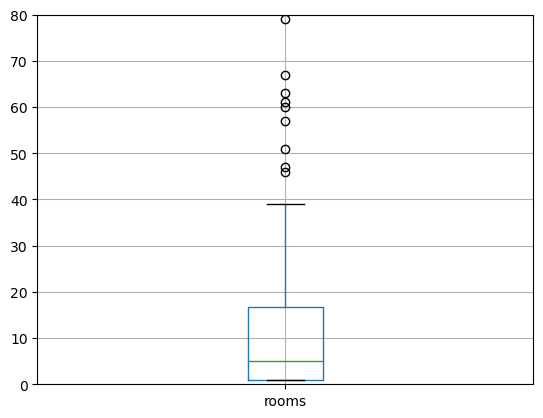

In [38]:
import matplotlib.pyplot as plt
bxl = data.pivot_table(index='ceiling_height', values='rooms', aggfunc='count')
plt.ylim(0, 80)
bxl.boxplot()
plt.show()


посмотрим на описание данных:

In [39]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.733740
std          0.425691
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         24.000000
Name: ceiling_height, dtype: float64

Среднее не сильно отличается от медианы, оставим данные в таком виде

<AxesSubplot:ylabel='Frequency'>

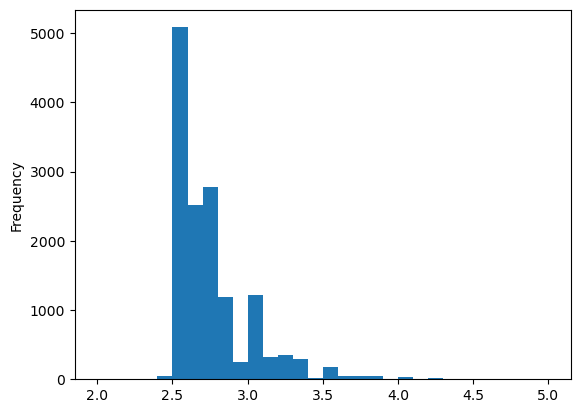

In [40]:
data['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 30, range=(2,5))

In [41]:

for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality_name), 'ceiling_height'] = median

Заполнение столцов airports_nearest, cityCenters_nearest и ponds_nearest вызывает затруднение, оставим пока как есть.
Еще раз проверим типы данных, заменим необходимые:

In [42]:
#копеек в цене нету, заменим на int для удобства просмотра
data['last_price'] = pd.to_numeric(data['last_price'], downcast='integer')

data['floors_total'] = pd.to_numeric(data['floors_total'], downcast='integer')
data['airports_nearest'] = pd.to_numeric(data['airports_nearest'], downcast='integer')
data['cityCenters_nearest'] = pd.to_numeric(data['cityCenters_nearest'], downcast='integer')
data['parks_nearest'] = pd.to_numeric(data['parks_nearest'], downcast='integer')
data['ponds_nearest'] = pd.to_numeric(data['ponds_nearest'], downcast='integer')
data['parks_around3000'] = pd.to_numeric(data['parks_around3000'], downcast='integer')
data['ponds_around3000'] = pd.to_numeric(data['ponds_around3000'], downcast='integer')
data['days_exposition'] = pd.to_numeric(data['days_exposition'], downcast='integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23578 non-null  float64       
 6   floors_total          23699 non-null  int8          
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

Изменив типы данных, мы умельниши объем используемой датафреймом памяти с 3.5мб до 2.8мб 

In [43]:
#дубликаты явные и неявные(только неявные)
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё','е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','городской поселок')
data = data.drop_duplicates()
data.duplicated().sum()
#Дубликатов  не обнаружено

data['locality_name'].unique()

array(['санкт-петербург', 'поселок шушары', 'городской поселок янино-1',
       'поселок парголово', 'поселок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'городской поселок красный бор', 'гатчина', 'деревня федоровское',
       'выборг', 'кронштадт', 'кировск', 'деревня новое девяткино',
       'поселок металлострой', 'городской поселок лебяжье',
       'городской поселок сиверский', 'поселок молодцово',
       'городской поселок кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'городской поселок ефимовский', 'поселок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'поселок новый свет', 'сланцы',
       'село путилово', 

**Вывод:**

В ходе преодобрабоки данных:
1. Были заполнены значемые строки для гипотез.
2. Была произведена смена типов данных.

In [44]:
data['last_price'].info()

<class 'pandas.core.series.Series'>
Int64Index: 23699 entries, 0 to 23698
Series name: last_price
Non-Null Count  Dtype
--------------  -----
23699 non-null  int32
dtypes: int32(1)
memory usage: 277.7 KB


In [45]:
data['last_price'] = data['last_price'].astype('int')
data['last_price'].info()

<class 'pandas.core.series.Series'>
Int64Index: 23699 entries, 0 to 23698
Series name: last_price
Non-Null Count  Dtype
--------------  -----
23699 non-null  int32
dtypes: int32(1)
memory usage: 277.7 KB






### Посчитайте и добавьте в таблицу новые столбцы

1. цена одного квадратного метра;
2. день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
3. месяц публикации объявления;
4. год публикации объявления;
5. тип этажа квартиры (значения — «‎первый», «последний», «другой»);
6. расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [46]:
#цена квадратного метра:
data['price_per_meter'] = data['last_price'] / data['total_area']
data['price_per_meter'] = data['price_per_meter'].astype('int')

#День, месяц, год публикации:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#Категоризируем этажи:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
data['floor_category'] = data.apply(floor_category, axis = 1)

#Переведём расстояние до цента города в км и округлим:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()
data['cityCenters_nearest_km'].describe()

count    18180.000000
mean        14.184818
std          8.616194
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: cityCenters_nearest_km, dtype: float64

In [47]:
#'first_day_exposition' уже был datetime я из нового датафрейма возьму потренируюсь
data1 = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
data['weekday_1'] = data1['first_day_exposition'].astype('datetime64[D]')

**Вывод:**

Подготовлены данные для ответа на гипотезы.

### Проведите исследовательский анализ данных

Изучите следующие параметры объектов, постройте отдельные гистограммы для каждого из этих параметров. Опишите все ваши наблюдения по параметрам.

- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

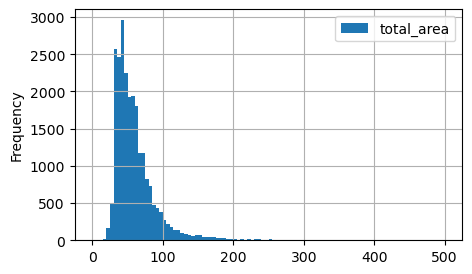

In [48]:
#изучим общую площадь
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))
data['total_area'].describe()
#распределение данных нормальное, есть выбросы но они не сильно влияют на данные
#describe использую для более полной картины

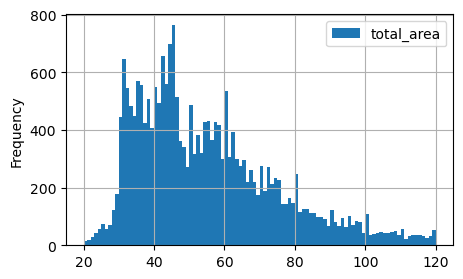

In [49]:
#Меняю range
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (20,120));

count    23699.000000
mean        34.562483
std         22.326966
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

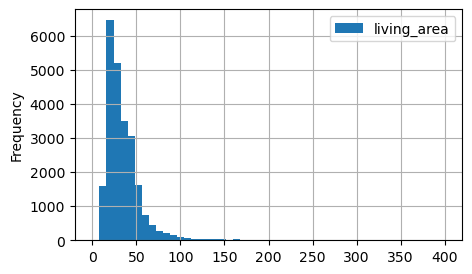

In [50]:
#изучим жилую площадь
data.plot(y = 'living_area', kind = 'hist', bins = 50, grid=True, figsize = (5,3), range = (0,400))
data['living_area'].describe()
#распределение данных нормальное, есть незначитлеьные выбросы 
#по гистограмме кроме распределения нечего больше указать, с помошью describe получил общее представление

Общая площадь по объектам недвижимости колеблется от 12 до 900 кв.м. Больше всего квартир в диапазоне 50-60 метров. Выбросы с площадью более 300 кв.м. вероятнее всего обусловлены индивидуальной планировкой, либо это частные дома. 
Жилая площадь колеблется от 2 до 409 кв.м. Среднее значение 34, медиана - 30. Описания аналогичны с общей площадью.


count    23699.000000
mean        10.579032
std          6.089020
min          1.300000
25%          7.000000
50%          9.080000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

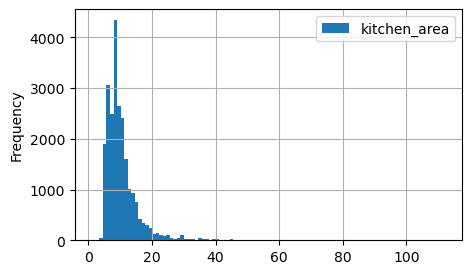

In [51]:
#Посмотрим на площадь кухни
data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3))
data['kitchen_area'].describe()

Выполняя предобработку, мы заменяли пропуски расчетным значением, которое не ставили, когда оно было меньше 5 кв.м. По данным можно сказать что самая популярная площадь кухни колеблется в районе 9-10 квадратных метров. Слишком большие значения опять могут говорить о индивидуальной планировке либо частном доме.


count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

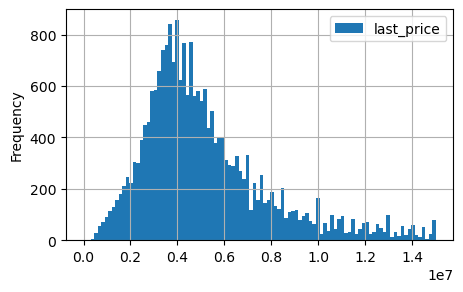

In [52]:
#Изучим цену
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (5,3))
data['last_price'].describe()

Можем говорить о средней стоимости жилья в 6.5 миллионов, медианное значение 4.65 млн. руб. Есть значения наподобие 12190 за квартиру, это я бы уточнил у сотррудников которые предоставляли данные. При возможности.

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

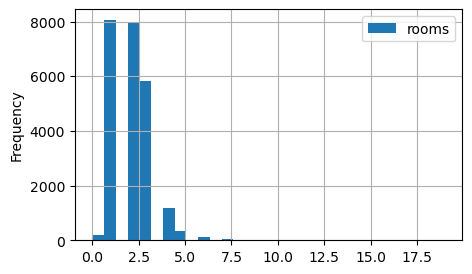

In [53]:
#Количество комнат:
data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (5,3))
data['rooms'].describe()

Максимальное количество комнат - 19. Чаще всего встречаются однокомнатные квартиры, с очень малым отставанием идут двухкомнатные.

count    23578.000000
mean         2.708622
std          0.339349
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max         24.000000
Name: ceiling_height, dtype: float64

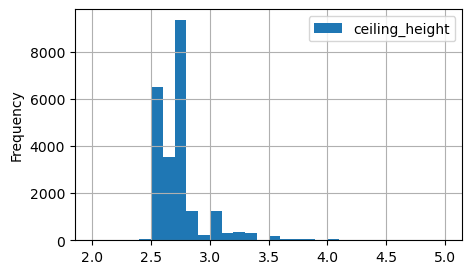

In [54]:
#Высота потолков:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
data['ceiling_height'].describe()

Высота потолков в составляет 2,73 метра, медианное значение 2,65. С данными все в порядке. 

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

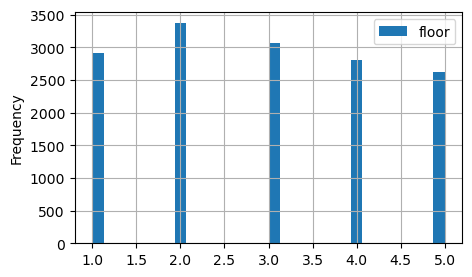

In [55]:
#Этаж квартиры
data.plot(y = 'floor', kind = 'hist', bins = 30, range = (1,5), grid=True, figsize = (5,3))
data['floor'].describe()

Жилье может распологаться от 1 до 33 этажа, незначительно больше других количество объявлений с квартирой на втором этаже. 

другой       17363
последний     3419
первый        2917
Name: floor_category, dtype: int64

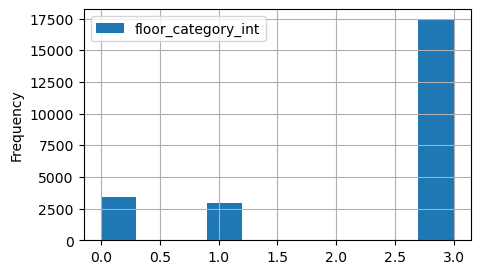

In [56]:
#Тип этажа квартиры 'floor_category'
#data.plot
#Можно было с помощью сводной  таблицы, я сделал еще одну колонку с числами для построения диаграммы
# Первый этаж - это 1 
#Последний этаж - 0
#Другие - 3
def floor_category_int(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return '1'
    elif floor == floors_total:
        return '0'
    elif 1 < floor < floors_total:
        return '3'
data['floor_category_int'] = data.apply(floor_category_int, axis = 1)
data['floor_category_int'] = data['floor_category_int'].astype('int')
data.plot(y = 'floor_category_int', kind = 'hist', grid=True, figsize = (5,3))
data['floor_category'].value_counts()

Можно сказать что квартир на последнем этаже (3419) больше чем квартир на первом (2917). Все остальные квартиры (которых большинство) находятся на других этажах.

count    23699.000000
mean        10.671463
std          6.595802
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

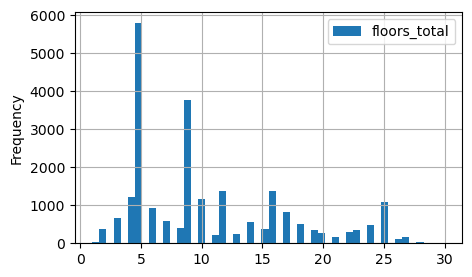

In [57]:
#Общее количество этажей в доме
data.plot(y = 'floors_total', kind = 'hist', bins=50, range = (1,30), grid=True, figsize = (5,3))
data['floors_total'].describe()

Больше всего предложений недвижимости в пятиэтажных домах, максимальная этажность здания - 60.

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

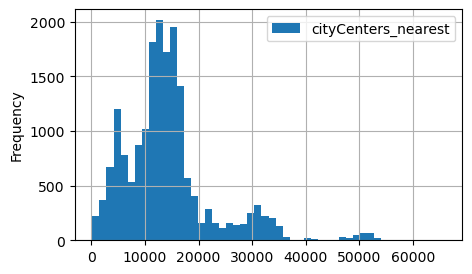

In [58]:
#Расстояние до центра города в метрах:
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins=50, grid=True, figsize = (5,3))
data['cityCenters_nearest'].describe()

В среднем расстояние до центра города составляет около 14 000 метров, медиана 13км (то есть основная масса объявлений будет в такой отдаленности от центра), также видны деревни/поселки/города на расстоянии 30км, 50 км

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

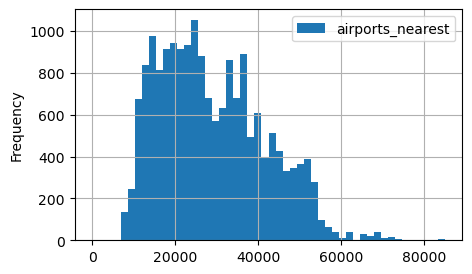

In [59]:
#Расстояние до ближайшего аэропорта:
data.plot(y = 'airports_nearest', kind = 'hist', bins=50, grid=True, figsize = (5,3))
data['airports_nearest'].describe()

Среднее расстояние до аэропорта 28.8 км, медиана - 26,7 максимальное расстояние до аэропорта ~85км. У нас только одно значение с расстоянием 0, следующее за ним минимальное значение - 6450 метров.

In [60]:
data[data['airports_nearest']!=0]['airports_nearest'].describe()

count    18156.000000
mean     28795.258096
std      12629.420568
min       6450.000000
25%      18585.000000
50%      26726.000000
75%      37273.500000
max      84869.000000
Name: airports_nearest, dtype: float64

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

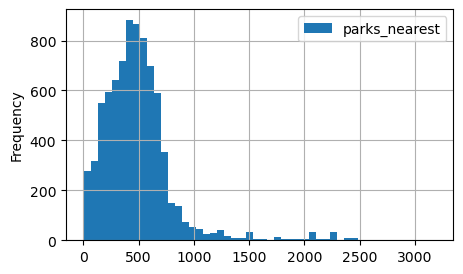

In [61]:
#Расстояние до ближайшего парка:
data.plot(y = 'parks_nearest', kind = 'hist', bins=50, grid=True, figsize = (5,3))
data['parks_nearest'].describe()

Большая часть недвижимости расположена на расстоянии 455 - 490 метров от ближайшего парка. Максимальное расстояние - около 3км.

count    23699.000000
mean         2.569307
std          1.789082
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday, dtype: float64

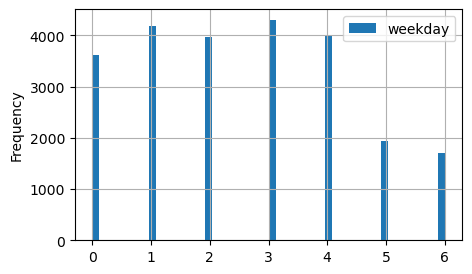

In [62]:
#День публикации объявления
data.plot(y = 'weekday', kind = 'hist', bins=50, grid=True, figsize = (5,3))
data['weekday'].describe()

count    23699.000000
mean         6.400101
std          3.491561
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

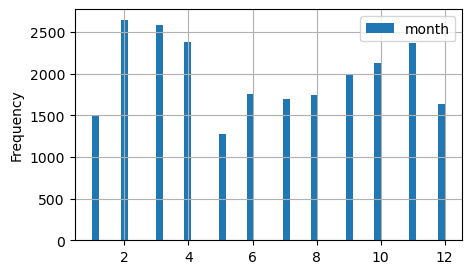

In [63]:
#Месяц публикации объявления
data.plot(y = 'month', kind = 'hist', bins=50, grid=True, figsize = (5,3))
data['month'].describe()

По времени публикации объявления можно сказать что меньше публикуют объявления по выходным, чаще всего по будням, без большого разброса, в наших данных лидирует среда.
Если смотреть по месяцам подачи, можно сказать, что в летнее время и в новый год объявлений подается меньше, чаще всего - февраль, март, апрель, сентябрь, октябрь, ноябрь. 

**Изучим как быстро продавались квартиры**

Для оценки скорости продажи квартиры будем использовать количество дней жизни объявления. Нам не уточняли является ли всегда это значение показателем того что квартира продана или объявление просто убрали. Мы заполнить пропущенные значения чем-то адекватным не можем, поэтому я заменил их на 0, но эти данные учитывать не буду при анализе.

In [64]:
data[data['days_exposition']!=0]['days_exposition'].value_counts()

45      880
60      538
7       234
30      208
90      204
       ... 
1021      1
1362      1
1105      1
795       1
971       1
Name: days_exposition, Length: 1141, dtype: int64

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

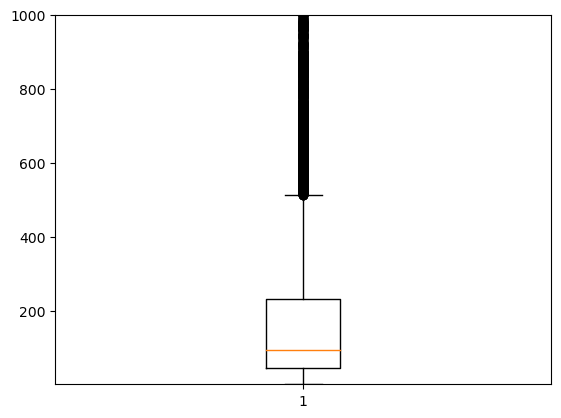

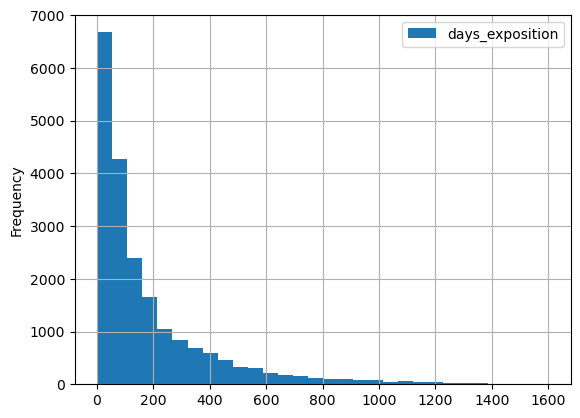

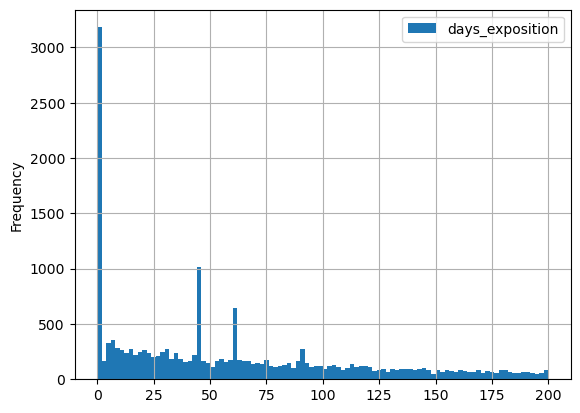

In [65]:
#boxplot
import matplotlib.pyplot as plt
plt.boxplot(data[data['days_exposition']!=0]['days_exposition'])
plt.ylim(1,1000)

data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (0,200))

#среднее значение, медиана и межквартильный размах
data[data['days_exposition']!=0]['days_exposition'].describe()
#data[data['days_exposition']!=0]['days_exposition'].value_counts()

Вывод: судя по гистограмме - мы имеем распределение Пуассона. Среднее значение - 180 дней, а медиана - 95 дней. Сделав гистограмму со значениями от 0 до 200 с кол-вом корзин 100, обнаружили выбивающиеся значения и методом value_counts убедились в этом - у нас аномалии на 45, 60, 90 днях - это наиболее популярное количество дней до снятия объявления, сюда также относим строки с 0 дней. Согласно правил размещения объявлений https://yandex.ru/support/realty/owner/home/add-ads-housing.html в зависимости от стоимости и типа объекта, указаны сроки публикации объявлений - как раз наши 45, 60, 90 дней.



In [66]:
data[data['days_exposition']==45]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_category,cityCenters_nearest_km,weekday_1,floor_category_int
78,9,4350000,37.0,2018-02-22,1,2.70,19,18.00,6,False,...,NaN,45,117567,3,2,2018,другой,14.0,2018-02-22,3
89,9,2500000,63.0,2018-10-25,3,2.50,5,43.00,4,False,...,NaN,45,39682,3,10,2018,другой,NaN,2018-10-25,3
110,6,3850000,72.3,2017-09-29,2,NaN,3,27.40,2,False,...,NaN,45,53250,4,9,2017,другой,NaN,2017-09-29,3
153,12,4350000,55.0,2017-05-21,2,2.57,9,31.20,2,False,...,NaN,45,79090,6,5,2017,другой,34.0,2017-05-21,3
158,15,3100000,47.3,2017-11-07,2,2.60,5,27.50,2,False,...,NaN,45,65539,1,11,2017,другой,NaN,2017-11-07,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23601,10,2900000,43.4,2018-01-11,2,2.70,5,24.51,1,False,...,397.0,45,66820,3,1,2018,первый,14.0,2018-01-11,1
23613,4,3950000,52.0,2018-03-04,3,2.64,5,29.37,2,False,...,NaN,45,75961,6,3,2018,другой,21.0,2018-03-04,3
23670,9,2450000,45.6,2018-02-08,1,2.80,9,25.75,2,False,...,NaN,45,53728,3,2,2018,другой,NaN,2018-02-08,3
23679,0,2500000,35.0,2017-12-08,1,2.50,9,19.77,4,False,...,NaN,45,71428,4,12,2017,другой,NaN,2017-12-08,3


Для получения более точных данных уберём аномалии. До того, как мы очистим наши данные от аномалий, нам нужно дать ответ на вопрос, какое количество дней считать нормальным, а какое выбросом на текущий момент до очистки данных. Исходя из метода describe, межквартильный размах - от 45 до 232 дней, исходя же из метода boxplot - диаграмма размаха у нас от минимального значения до примерно 500 дней. Значит необоснованно быстрых значений у нас нет, а необоснованно долгие - от 500 дней и выше. Значит нормальные значения у нас лежат от 1 до 500.

На текущий момент мы уже знаем, что эти данные неправильные, но они нам нужны, чтобы сравнить с данными, очищенными от аномалий далее.

Считаю важным уточнить у сотрудников насчет выбивающихся значений по датам снятия объявлений, чтобы убедиться в том, какие данные необходимо исключить из выборки. 
исключим значения в 45, 60, 90 и 0 дней размещения

count    18896.000000
mean       191.640188
std        225.707795
min          1.000000
25%         41.000000
50%        110.000000
75%        252.000000
max       1580.000000
Name: days_exposition, dtype: float64

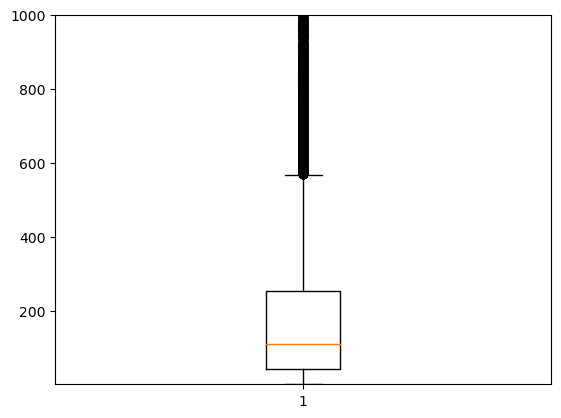

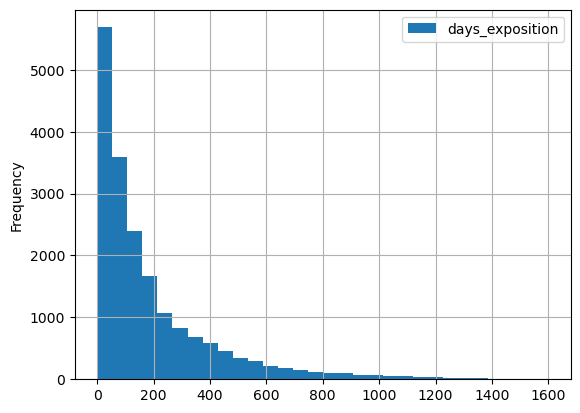

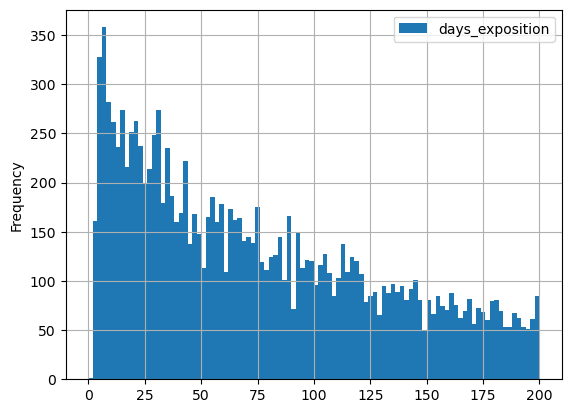

In [67]:
#отфильтруем данные от аномалий и запишем их в новый датафрейм
good_data = data.query('days_exposition != 45 and days_exposition != 60 and days_exposition != 90 and days_exposition != 0')

#диаграмма размаха
plt.boxplot(good_data['days_exposition'])
plt.ylim(1,1000)

#гистограммы
good_data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (0,1600))
good_data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (0,200))

#среднее значение, медиана и межквартильный размах
#good_data['days_exposition'].value_counts()
good_data['days_exposition'].describe()

Вывод: ожидаемо, в очищенных данных с аномалиями в значениях меньших медианы получаем бОльшие значения медианы и среднего значения - 110 и 195 соответственно, вместо 95 и 180. Аналогично, теперь нормальные значения располагаются от 1 до 600 дней вместо от 1 до 500 дней.
Таким образом можем говорить что в среднем квартира продается за 195 дней, половина квартир уходит за 110 дней в среднем. Быстрым можно назвать продажу квартиры можно назвать менее 40 дней, а если не продается более 250 дней - можно говорить что уже долго.

**Изучим зависимость цены от общей площади квартиры.**


0.6536750579657242

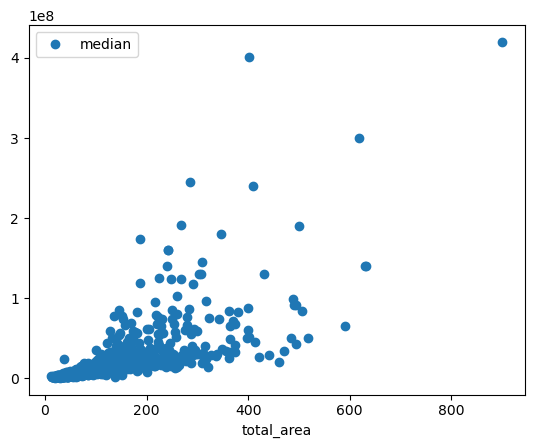

In [68]:
pivot_table_total_area = data.pivot_table(index = 'total_area',
                                          values = 'last_price',
                                          aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
#pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['last_price'])

Можно сказать, что есть зависимость:
чем больше общая площадь, тем, в основном скорее всего, больше будет стоить жильё. На самом деле это понятно и без картинки. Коэффициент корреляции говорит что зависимость не прямая, но она есть. 

0.585658034484759

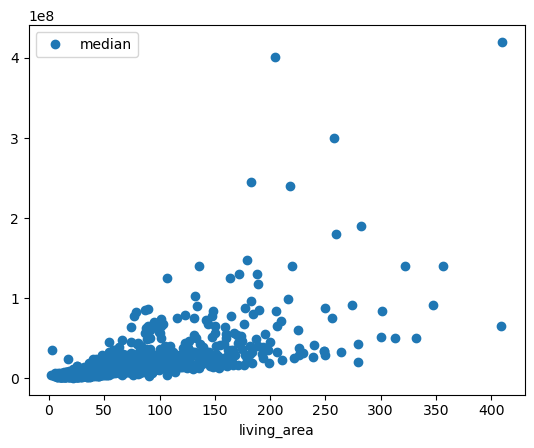

In [69]:
#зависимость цены квадратного метра от жилой площади квартиры
pivot_table_living_area = data.pivot_table(index = 'living_area',
                                          values = 'last_price',
                                          aggfunc = ['mean', 'count', 'median'])
pivot_table_living_area.columns = ['mean', 'count', 'median']
pivot_table_living_area.plot(y = 'median', style = 'o')
#pivot_table_living_area.sort_values('median', ascending = False)

data['living_area'].corr(data['last_price'])

Видим что коэффициент корреляции стал меньше, все равно говорим о зависомости. Цена квадратного метра может расти с увеличением жилой площади. 

0.5167542539320581

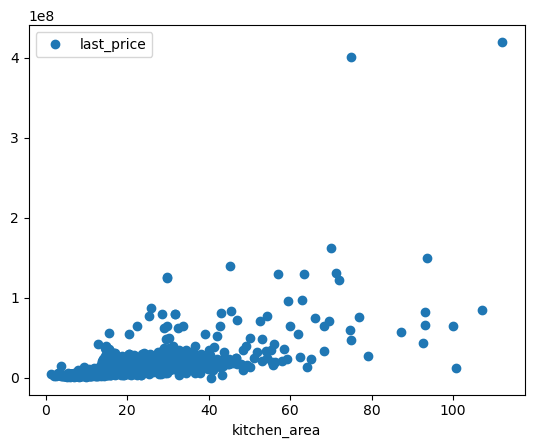

In [70]:
pivot_table_kitchen_area = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = 'median')

pivot_table_kitchen_area.plot(y = 'last_price', style = 'o')


data['kitchen_area'].corr(data['last_price'])

Тоже можно говорить о зависимости: чем больше площадь кухни, тем дороже будет квартира.

0.3633428499648955

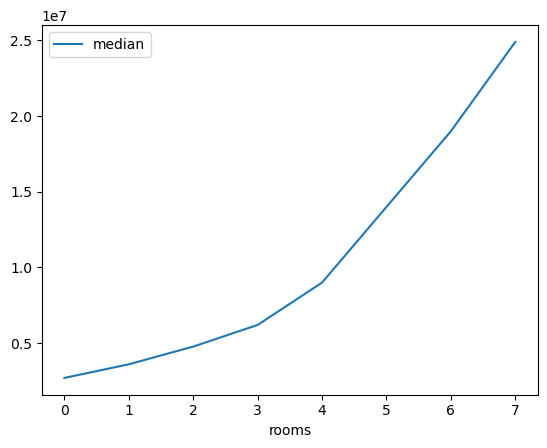

In [71]:
#Изучим зависимость полной цены от количества комнат:
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')

#pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)

data['rooms'].corr(data['last_price'])

В целом видим по графику, что чем больше комнат в квартире, тем дороже она будет стоить.

,mean,count,median
floor_category,,,
другой,6.674074e+06,17363,4850000
первый,4.803560e+06,2917,3900000
последний,7.351339e+06,3419,4350000


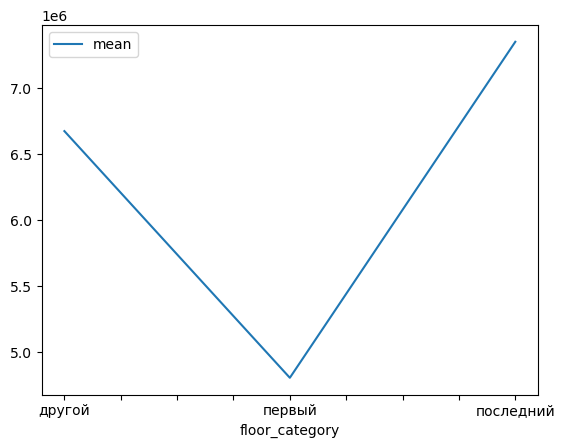

In [72]:
pivot_table_floor_category1 = data.pivot_table(
    index = 'floor_category', 
    values = 'last_price', 
    aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category1.columns = ['mean', 'count', 'median']
pivot_table_floor_category1.plot(y = 'mean')
pivot_table_floor_category1

In [73]:
#Переведём цену в миллионы для удобства 
data['last_price'] = data['last_price']/1000000
data['last_price']

0        13.000
1         3.350
2         5.196
3        64.900
4        10.000
          ...  
23694     9.700
23695     3.100
23696     2.500
23697    11.475
23698     1.350
Name: last_price, Length: 23699, dtype: float64

По графику можем сказать только то что цена квартир на первом этаже ниже цены на последнем этаже здания. Посмотрим на распределение цен внутри категорий:

In [74]:
print(data[data['floor_category'] == 'первый']['last_price'].describe())

count    2917.000000
mean        4.803560
std         5.098889
min         0.430000
25%         2.800000
50%         3.900000
75%         5.400000
max       135.000000
Name: last_price, dtype: float64


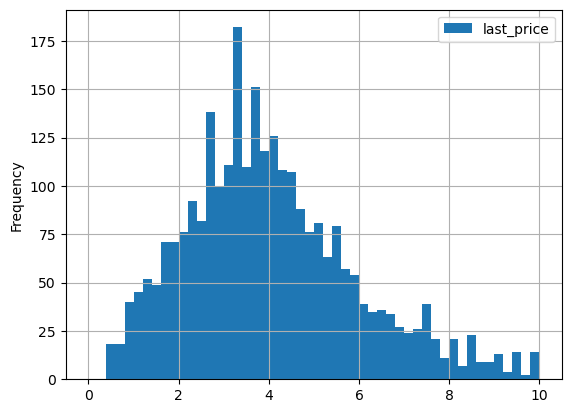

In [75]:
data[data['floor_category'] == 'первый'].plot(y = 'last_price', kind = 'hist', bins = 50, grid = True, range = (0,10));


На первом этаже можно купить квартиру от 430 тысяч до 135 миллионов. Средняя стоимость квартиры на первом этаже 4.8 млн. Медианное значение 3.9 млн. Больше всего предложений за примерно 3.5 млн. руб.

In [76]:
print(data[data['floor_category'] == 'последний']['last_price'].describe())

count    3419.000000
mean        7.351339
std        20.458605
min         0.012190
25%         3.000000
50%         4.350000
75%         6.800000
max       763.000000
Name: last_price, dtype: float64


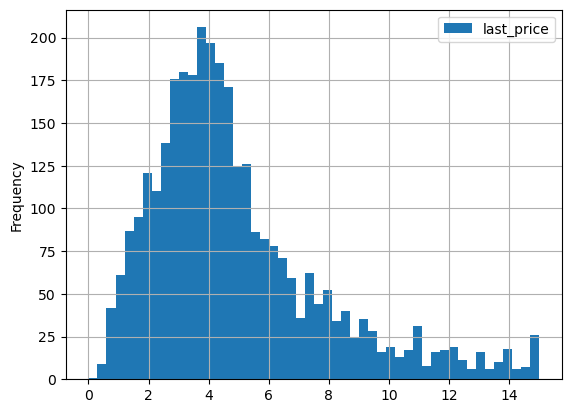

In [77]:
data[data['floor_category'] == 'последний'].plot(y = 'last_price', kind = 'hist', bins = 50, grid = True, range = (0,15));

На последнем этаже видим, что квартиры будут дороже. Средняя стоимость будет около 7.35 млн. руб. Больше всего квартир в этой категории стоимостью около 4 млн. руб. 

In [78]:
print(data[data['floor_category'] == 'другой']['last_price'].describe())

count    17363.000000
mean         6.674074
std          8.623312
min          0.450000
25%          3.600000
50%          4.850000
75%          7.000000
max        330.000000
Name: last_price, dtype: float64


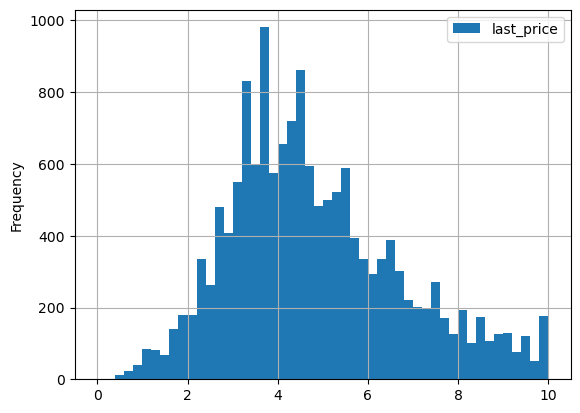

In [79]:
data[data['floor_category'] == 'другой'].plot(y = 'last_price', kind = 'hist', bins = 50, grid = True, range = (0,10));

бОльшая часть квартир расположена на этажах, отличных от первого и последнего. Средняя стоимость около 6.67 млн. руб., медиана - 4.85. Чаще всего продаются квартиры с ценой в диапазоне 3.5 - 3.8 млн. руб. 

In [80]:
#Посмотрим на зависимость цены квартиры от дня, месяца, года подачи объявления
priсe_daily = data.loc[:,['last_price', 'weekday', 'month', 'year']]
priсe_daily.head()

,last_price,weekday,month,year
0,13.000,3,3,2019
1,3.350,1,12,2018
2,5.196,3,8,2015
3,64.900,4,7,2015
4,10.000,1,6,2018


In [81]:
priсe_daily.corr()

,last_price,weekday,month,year
last_price,1.000000,0.001550,0.002779,-0.043089
weekday,0.001550,1.000000,0.011496,-0.004799
month,0.002779,0.011496,1.000000,-0.269642
year,-0.043089,-0.004799,-0.269642,1.000000


Коэффициенты корреляции говорят о очень слабой зависимости, пройдем по каждой колонке для подтверждения гипотезы.

count    3612.000000
mean        6.511613
std         9.631997
min         0.430000
25%         3.450000
50%         4.650000
75%         6.700000
max       300.000000
Name: last_price, dtype: float64


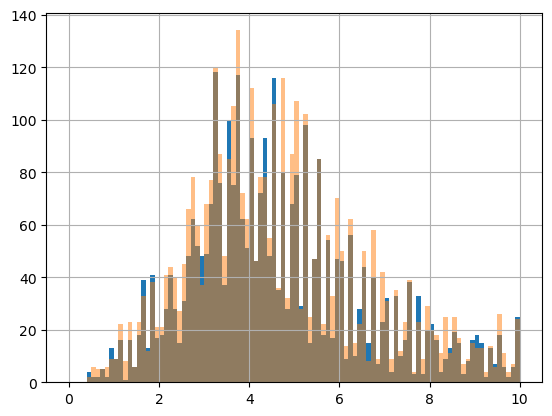

In [82]:
print(priсe_daily[priсe_daily['weekday'] == 0]['last_price'].describe())
priсe_daily[priсe_daily['weekday'] == 0]['last_price'].hist(bins=100, range=(0,10))
priсe_daily[priсe_daily['weekday'] == 1]['last_price'].hist(bins=100, range=(0,10), alpha=0.5);

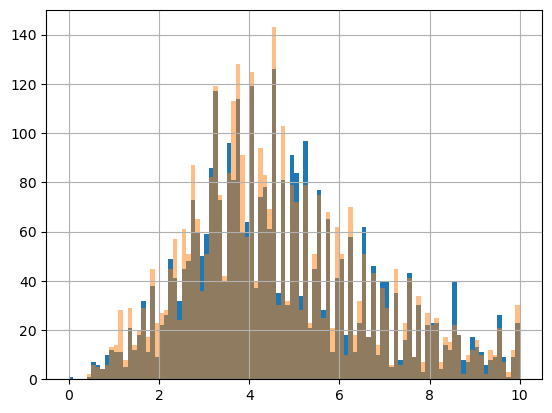

In [83]:
priсe_daily[priсe_daily['weekday'] == 2]['last_price'].hist(bins=100, range=(0,10))
priсe_daily[priсe_daily['weekday'] == 3]['last_price'].hist(bins=100, range=(0,10), alpha=0.5);

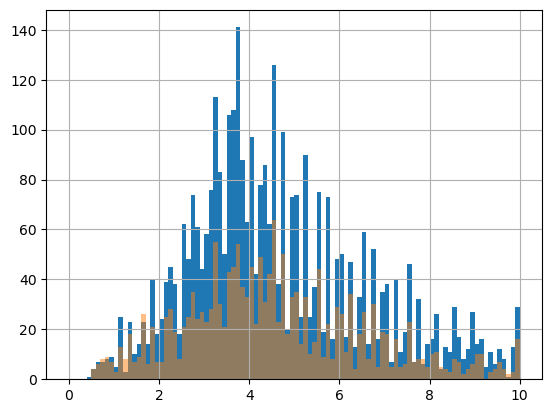

In [84]:
priсe_daily[priсe_daily['weekday'] == 4]['last_price'].hist(bins=100, range=(0,10))
priсe_daily[priсe_daily['weekday'] == 5]['last_price'].hist(bins=100, range=(0,10), alpha=0.5);

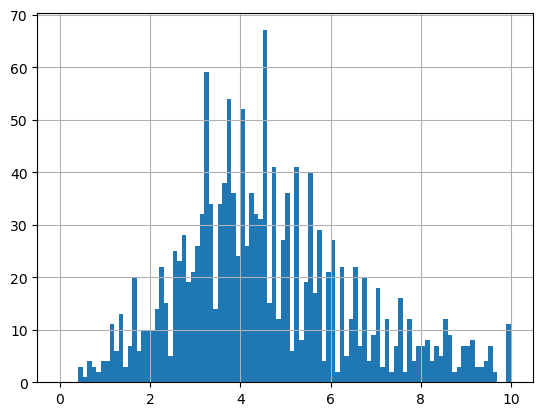

In [85]:
priсe_daily[priсe_daily['weekday'] == 6]['last_price'].hist(bins=100, range=(0,10));

Цена квартиры не зависит от дня продажи, меняется только количество проданных квартир, болше квартир продается в будние дни, когда работают риелторы, агенства и банки.

Изучим гистограммы по месяцам.

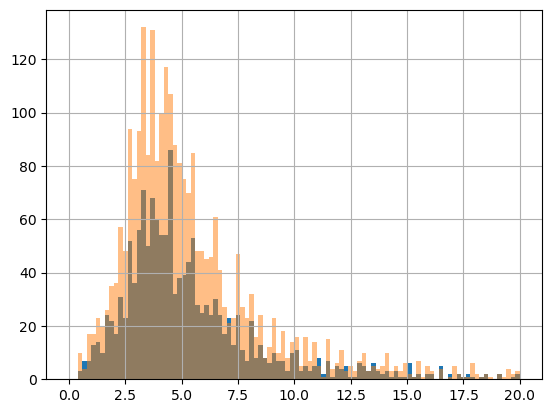

In [86]:
priсe_daily[priсe_daily['month'] == 1]['last_price'].hist(bins=100, range=(0,20))
priсe_daily[priсe_daily['month'] == 2]['last_price'].hist(bins=100, range=(0,20), alpha=0.5);

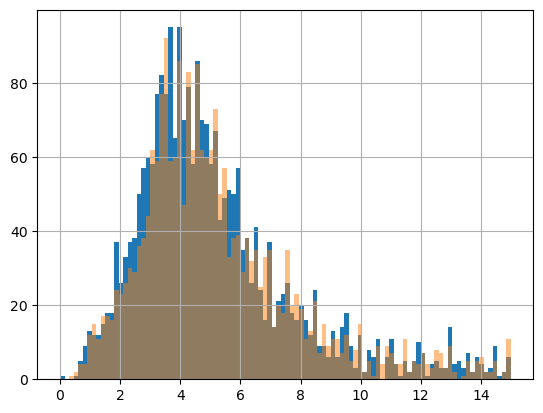

In [87]:
priсe_daily[priсe_daily['month'] == 3]['last_price'].hist(bins=100, range=(0,15))
priсe_daily[priсe_daily['month'] == 4]['last_price'].hist(bins=100, range=(0,15), alpha=0.5);

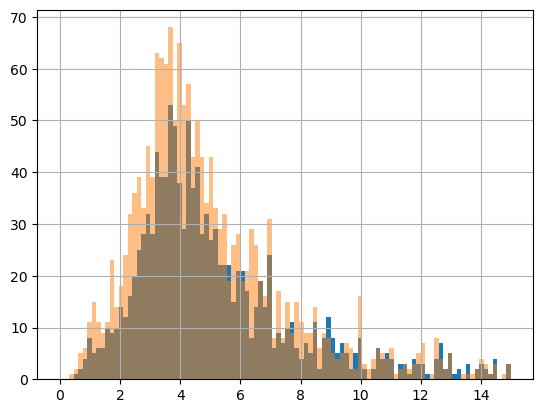

In [88]:
priсe_daily[priсe_daily['month'] == 5]['last_price'].hist(bins=100, range=(0,15))
priсe_daily[priсe_daily['month'] == 6]['last_price'].hist(bins=100, range=(0,15), alpha=0.5);

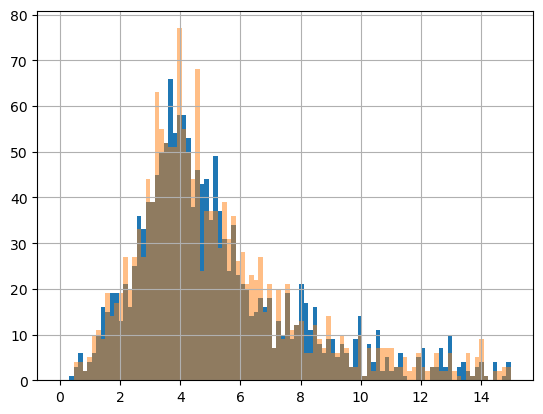

In [89]:
priсe_daily[priсe_daily['month'] == 7]['last_price'].hist(bins=100, range=(0,15))
priсe_daily[priсe_daily['month'] == 8]['last_price'].hist(bins=100, range=(0,15), alpha=0.5);

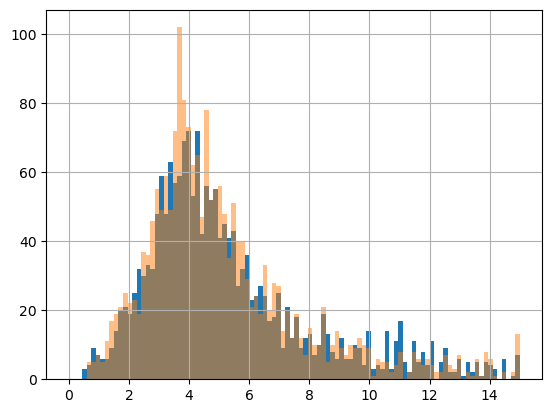

In [90]:
priсe_daily[priсe_daily['month'] == 9]['last_price'].hist(bins=100, range=(0,15))
priсe_daily[priсe_daily['month'] == 10]['last_price'].hist(bins=100, range=(0,15), alpha=0.5);

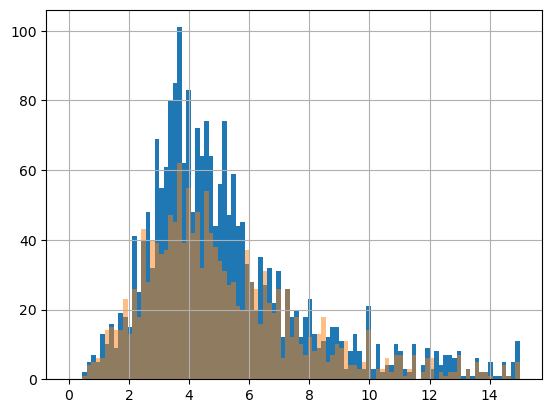

In [91]:
priсe_daily[priсe_daily['month'] == 11]['last_price'].hist(bins=100, range=(0,15))
priсe_daily[priсe_daily['month'] == 12]['last_price'].hist(bins=100, range=(0,15), alpha=0.5);

По графикам видим полпулярную цену на квартиры в районе 4-5 млн.руб. Зависимости цены от даты не наблюдаем, можем только говорить о спаде продаж в мае, январе и декабре. 

Посмотрим на колонку год:

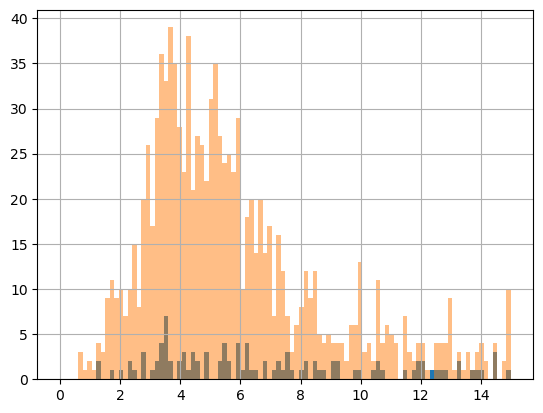

In [92]:
#priсe_daily['year'].unique()
priсe_daily[priсe_daily['year'] == 2014]['last_price'].hist(bins=100, range=(0,15))
priсe_daily[priсe_daily['year'] == 2015]['last_price'].hist(bins=100, range=(0,15), alpha=0.5);

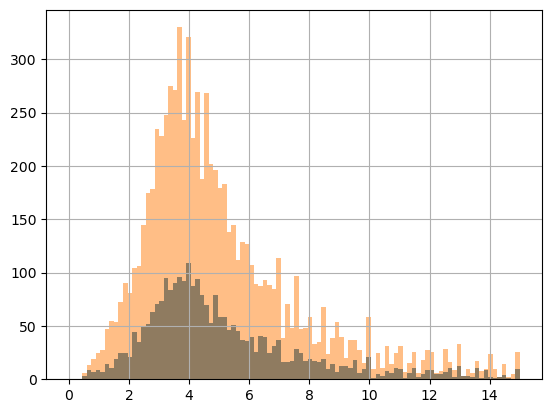

In [93]:
priсe_daily[priсe_daily['year'] == 2016]['last_price'].hist(bins=100, range=(0,15))
priсe_daily[priсe_daily['year'] == 2017]['last_price'].hist(bins=100, range=(0,15), alpha=0.5);

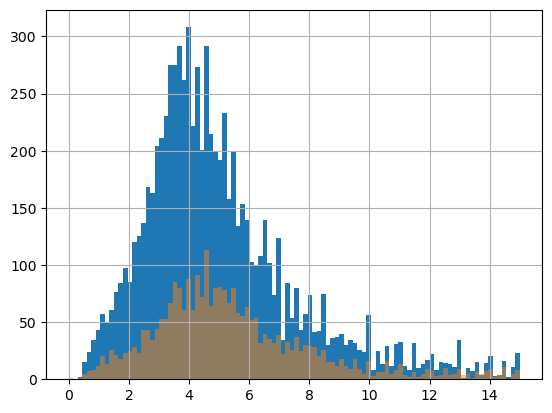

In [94]:
priсe_daily[priсe_daily['year'] == 2018]['last_price'].hist(bins=100, range=(0,15))
priсe_daily[priсe_daily['year'] == 2019]['last_price'].hist(bins=100, range=(0,15), alpha=0.5);

По графикам видим что колеблется количество объявлений, зависимости цены от года продажи установить не удалось. Можно говорить о небольшом смещении в сторону удорожания, что можно объяснить инфляцией.

#Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Предобработку по названиям населенных пунктов мы уже сделали. Создадим переменную в которой будем хранить 10 населенных пунктов с наибольшим числом объявлений. 

In [95]:
top_10_locality_name = data['locality_name'].value_counts()[:10]
top_10_locality_name = top_10_locality_name.index
top_10_locality_name

Index(['санкт-петербург', 'поселок мурино', 'поселок шушары', 'всеволожск',
       'пушкин', 'колпино', 'поселок парголово', 'гатчина', 'деревня кудрово',
       'выборг'],
      dtype='object')

In [96]:
top_10_pivot_table = (data
                      .query('locality_name in @top_10_locality_name')
                      .pivot_table(index='locality_name', values='price_per_meter', aggfunc='mean')
                      .sort_values('price_per_meter', ascending=False))
top_10_pivot_table

,price_per_meter
locality_name,
санкт-петербург,114848.565231
пушкин,103125.373984
деревня кудрово,92473.086957
поселок парголово,90175.489297
поселок мурино,85681.305755
поселок шушары,78676.904545
колпино,75424.150888
гатчина,68745.693811
всеволожск,68654.007538


In [97]:
top_10_pivot_table_1 = (data
                      .query('locality_name in @top_10_locality_name')
                      .pivot_table(index='locality_name', values='price_per_meter', aggfunc='median')
                      .sort_values('price_per_meter', ascending=False))
top_10_pivot_table_1

,price_per_meter
locality_name,
санкт-петербург,104761.0
пушкин,100000.0
деревня кудрово,91860.0
поселок парголово,91642.0
поселок мурино,85878.0
поселок шушары,76876.0
колпино,74723.5
гатчина,67796.0
всеволожск,65789.0


In [98]:
top_10_pivot_table_min_max = (data
                      .query('locality_name in @top_10_locality_name')
                      .pivot_table(index='locality_name', values='price_per_meter', aggfunc=['min','max']))
top_10_pivot_table_min_max

,min,max
,price_per_meter,price_per_meter
locality_name,,
всеволожск,31400,640422
выборг,18750,107473
гатчина,10507,146315
деревня кудрово,54160,142857
колпино,47957,125000
поселок мурино,50000,138580
поселок парголово,39205,138522
поселок шушары,47700,147826


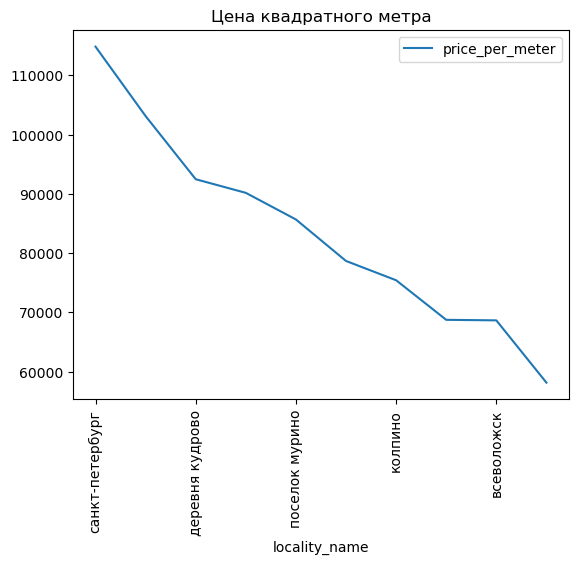

In [99]:
top_10_pivot_table.plot(kind='line', title = 'Цена квадратного метра', rot=90);

По данным видим что везде победил Санкт-Петербург. У него самая большая средняя за кв.м., самые дешевые и самые дорогие квадратные метры жилья также у Санкт-Петербурга.


Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города


In [116]:
SP_data = data.query('locality_name == "санкт-петербург"')
SP_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15721 entries, 0 to 23697
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            15721 non-null  int64         
 1   last_price              15721 non-null  float64       
 2   total_area              15721 non-null  float64       
 3   first_day_exposition    15721 non-null  datetime64[ns]
 4   rooms                   15721 non-null  int64         
 5   ceiling_height          15721 non-null  float64       
 6   floors_total            15721 non-null  int8          
 7   living_area             15721 non-null  float64       
 8   floor                   15721 non-null  int64         
 9   is_apartment            15721 non-null  bool          
 10  studio                  15721 non-null  bool          
 11  open_plan               15721 non-null  bool          
 12  kitchen_area            15721 non-null  float6

In [117]:
SP_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_category,cityCenters_nearest_km,weekday_1,floor_category_int
0,20,13.000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,755.0,0,120370,3,3,2019,другой,16.0,2019-03-07,3
2,10,5.196,56.00,2015-08-20,2,2.70,5,34.30,4,False,...,574.0,558,92785,3,8,2015,другой,14.0,2015-08-20,3
3,0,64.900,159.00,2015-07-24,3,2.70,14,89.80,9,False,...,234.0,424,408176,4,7,2015,другой,7.0,2015-07-24,3
4,2,10.000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,48.0,121,100000,1,6,2018,другой,8.0,2018-06-19,3
7,5,7.915,71.60,2019-04-18,2,2.70,24,40.44,22,False,...,NaN,0,110544,3,4,2019,другой,12.0,2019-04-18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,3.550,35.30,2018-02-28,1,2.86,15,16.30,4,False,...,652.0,29,100566,2,2,2018,другой,16.0,2018-02-28,3
23690,3,5.500,52.00,2018-07-19,2,2.70,5,31.00,2,False,...,NaN,15,105769,3,7,2018,другой,6.0,2018-07-19,3
23691,11,9.470,72.90,2016-10-13,2,2.75,25,40.30,7,False,...,806.0,519,129903,3,10,2016,другой,4.0,2016-10-13,3
23694,9,9.700,133.81,2017-03-21,3,3.70,5,73.30,3,False,...,381.0,0,72490,1,3,2017,другой,4.0,2017-03-21,3


In [120]:
#prevent SettingWithCopyWarning message from appearing
pd.options.mode.chained_assignment = None

In [121]:
#Колонка с километрами была, но я для удобства, создал новый датафрейм, переведу и округлю еще раз
SP_data['kilometers_from_center'] = (SP_data['cityCenters_nearest']/1000).round()


In [112]:
SP_data['kilometers_from_center'].value_counts().index

Float64Index([12.0, 15.0, 13.0, 14.0, 16.0, 11.0,  5.0, 17.0, 10.0,  4.0,  6.0,
               8.0,  9.0,  7.0,  3.0,  2.0, 18.0, 22.0,  1.0, 19.0, 21.0, 23.0,
              26.0, 20.0,  0.0, 25.0, 24.0, 28.0, 29.0, 27.0],
             dtype='float64')

In [103]:
price_per_km = (SP_data
               .pivot_table(index='kilometers_from_center', values='price_per_meter', aggfunc='mean'))
price_per_km

,price_per_meter
kilometers_from_center,
0.0,245833.111111
1.0,177004.963542
2.0,157848.564516
3.0,121386.991429
4.0,133282.422965
5.0,140509.339130
6.0,151011.750809
7.0,156176.445238
8.0,125671.030151


In [104]:
plot_price_per_km = price_per_km
plot_price_per_km['km'] = price_per_km.index
plot_price_per_km

,price_per_meter,km
kilometers_from_center,,
0.0,245833.111111,0.0
1.0,177004.963542,1.0
2.0,157848.564516,2.0
3.0,121386.991429,3.0
4.0,133282.422965,4.0
5.0,140509.339130,5.0
6.0,151011.750809,6.0
7.0,156176.445238,7.0
8.0,125671.030151,8.0


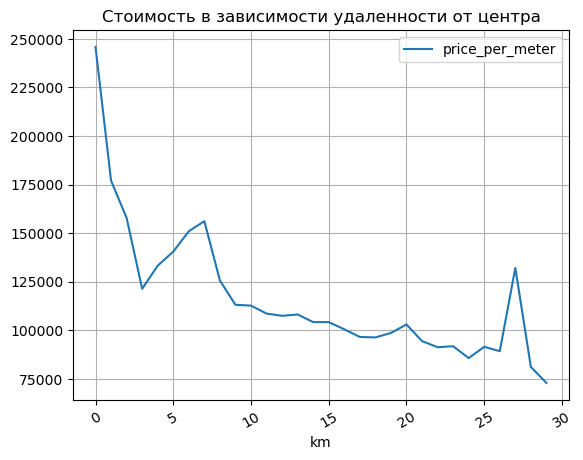

-0.7676912838138894

In [105]:
price_per_km.plot(x='km', y='price_per_meter' ,kind='line', title = 'Стоимость в зависимости удаленности от центра', grid = True)
plt.xticks(rotation=30)
plt.show()
plot_price_per_km['price_per_meter'].corr(plot_price_per_km['km'])

Видим обратную зависимость удалённости от центра и цены за кв.м. Чем дальше от центра, тем дешевле будет стоить кв.м. жилья. Есть пики в районе 7 км и 26км (это скорее всего Петергоф). 

### Общий вывод
Было проведено исследование объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. 
Проведена работа по данному проекту:
- Были определены аномалии и построена стратегия замены пропусков.
- Пропуски были заполнены максимально возможными способами, чтобы каждое значение могло влиять на гипотезы.
- Приведены типы данных для уменьшения используемой памяти и отображаемого вида в таблице.
- Созданы дополнительные столбцы для улучшения анализа данных.
- Были изучены параметры объектов.

**Как быстро продавались квартиры**

Можно говорить что среднне время продажи квартиры - примерно 195 дней, если квартира продалась за 40 дней - это быстро, 250 дней размещения объявления - долгая продажа квартиры. Также было установлено, что есть объявления, которые размещены около 600 дней и это не является аномалией или выбросом.


**Факторы, влияющие на полную стоимость объекта**

Были изучены параметры:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Цена объекта больше всего зависит от его площади, чуть меньше жилой площади и площади кухни. Этажность говорит о том, что самые непопулярные квартиры расположены на крайних этажах (первом и последнем, причем первый кажется хуже), соответсвенно будет от этого меняться и цена - квартиры у которых никто не будет смотреть/лезть тебе в окна или в которой не потечёт крыша - будут стоить дороже. 
Дату продаж с ценой связать трудно. Можно использовать эти выводы для проведения рекламных кампаний, чтобы определить, в какой момент лучше продвигать рекламную компанию по продаже домов. В какие месяцы или дни недели. Видим, что количество продаж по будням выше. Также наблюдается спад продаж в новогодние месяцы и летние.  

**Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**

Можем говорить о снижении стоимости жилья в пригородах Санкт-Петербурга ввиду снижения престижности. 
По нашим данным как самый дорогой кв.м. так и самый дешевый находятся в Санкт-Петербурге. Возникают подозрения про самый дешевый, при возможности можно обратиться к тому кто предоставлял данные, глядя на тенденцию снижения цены при удалении от центра, самый дешевый метр должен быть удален от города.  
Если смотреть по отдаленности от центра города, можем говорить о тенденции снижения цены с увеличением расстояния до центра.

**Общие рекомендации**

Говоря о центре Санкт-Петербурга, чем ближе к центру тем дороже квартира.

Самая популярная квартира - 1- или 2-комнатная с общей площадью 60 кв.м., жилой площадью 35 кв.м., с кухней около 10 кв.м., стоимостью 4-5 млн. руб. с высотой потолка 2.7 метров, в пятэтажном доме, в 400м от парка и 28 км. от аэропорта. 


Квартиры чаще всего продаются в течении 40 дней, самым долгим будет продажа в диапазоне 250 и больше дней. 

Больше всего влияет на цену - близость к центру, после по уменьшению влияния: площадь, кол-во комнат, первый или последний этаж.

БОльшим спросом пользуются квартиры которые не расположены на первом и последнем этаже, так же этот факт больше влияет на цену. 



* Данные были обработаны - убраны пропуски, возможные артефакты минимзировано воздействие выбросов на выводы по гипотезам
* Были обработаны и убраны явные и неявные дубликаты.
* Данные были проверены по колонкам по каждому описанию.
* Для ответов на гипотезы сделана визуализация.